# Homework 1
**The goal of this homework is to improve the simple classifier explained in the book starting on page 40. It uses a pretrained transformer and then the logistic regression classifier of page 44 uses only the first hidden state for each input text.**

**You should use the full hidden states to classify each input text, and use a neural network instead of a regression classifier. Then, compare the results with the book’s on page 44.**

**You have 11 days to do it, by pairs. Start working early as you may need computing time to get the results. Please submit a Jupyter notebook or similar, and include some conclusions.**

## Solution
**Authors: Frank William Hammond Espinosa, Maria dels Àngels Llobera González**

**Date: March 17th, 2025**

### Equipment
Training was carried out on a 12 GB NVIDIA RTX 4070 GPU owned by one of the authors.

### Requirements

Execution of this notebook assumes a "fresh" Python 3.13.2 interpreter.

Check the `requirements.txt` file on the root of the project for the necessary dependencies. They will be installed when executing the first code cell.

### Preliminaries
First, we make sure to install and import the necessary libraries, and specify the device `pytorch` should use (`cuda` in our case, but for compatibility with non-CUDA systems `cpu` may be used, albeit execution will be much slower).

We also define a useful utility method `print_available_memory`. It prints the currently available GPU memory. It was used thoroughly during training to track memory usage since on early stages we faced issues with the capacity of the graphics card.

In [1]:
%pip install -r requirements.txt

import torch
import torch.nn as nn
import numpy as np
from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def print_available_memory(device=device):
    free, total = torch.cuda.mem_get_info(device)
    free = free/1024**3
    total = total/1024**3
    print("Memory available: {:.3f}/{:.3f}GB".format(free, total))

Note: you may need to restart the kernel to use updated packages.


/home/frank/Desktop/code/data_mining/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We now load the dataset. Notice how most of the memory of the GPU is still available, since the dataset was loaded into regular RAM memory instead of GPU.

In [2]:
emotions_dataset = load_dataset("emotion")
print_available_memory(device)

Memory available: 10.347/11.584GB


Now we will use a pretrained model to transform the text into numerical representations. The model chosen was `distilbert-base-uncased`, as in the book. 

Notice how, for the tokenizer, the flag `padding=True` is set. This means that shorter sentences will be appended zeros at the end so as to have all the same length. An `attention_mask` is used to tell the language model it shouldn't process those zeros as regular tokens and just output zeros on those positions as well. Padding will become important later on when classifying. The `truncation=True` flag truncates the token sequences to fit the context window of the model. It is probably unnecessary since the token sequences aren't too long anyway (there used to be a hard limit on the number of characters per tweet), but is nevertheless a good idea to set it in order to prevent execution errors later.

In [3]:
model_checkpoint = "distilbert-base-uncased"
model = AutoModel.from_pretrained(model_checkpoint).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
print_available_memory(device)

Memory available: 10.032/11.584GB


Notice how the model was not memory-heavy at all even when explicitly loaded onto the GPU. It's actually a very small model: the `.safetensors` file of weights on its official [Hugging Face repository](https://huggingface.co/distilbert/distilbert-base-uncased) is only 268MB (approximately the difference between the two outputs of `print_available_memory` so far).

Its small size is due to the fact its a distilled model and not the actual BERT. This means outputs of this model can be suboptimal when compared to a full-blown LLM.


Now we tokenize each of the samples in the dataset.

We are interested in the maximum length of token sequences among all of the dataset since we will need this for additional padding later. Due to the way the `transformer` dataset API works, it's more comfortable to pad token sequences twice: the `map` method appplies the `tokenize` function to each subset of data (among `train`, `validation` and `test`) separately, and due to the `padding=True` flag we set earlier, this pads each subset to its own, respective maximum length. But these lenghts may differ themselves, hence why we store their maximum length to be used for further padding later.

In [4]:
emotions_encoded = emotions_dataset.map(tokenize, batched=True, batch_size=None)
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

max_length = max([emotions_encoded[subset]['input_ids'].shape[1] for subset in emotions_encoded.keys()])
print(emotions_encoded)
print(max_length)

print_available_memory(device)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})
87
Memory available: 10.013/11.584GB


Again, not much memory was used since the encodings have not (yet) been loaded into the GPU.

Now we actually compute the vector representations of the token sequences using the language model. Notice how the resulting matrices are transformed into vectors and then padded with trailing zeros to all have the same size. This is done so that a regular feed-forward neural network can be evaluated and trained on their classification.

In [5]:
def compute_hidden_states(batch):
    global max_length
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    batch_size, sequence_length, hidden_dim = last_hidden_state.shape
    tensor = last_hidden_state.reshape(batch_size, sequence_length*hidden_dim)

    padding = (max_length - sequence_length) * hidden_dim
    padded = nn.functional.pad(tensor, (0, padding), "constant", 0)
    return {"hidden_state": padded}
        
emotions_hidden = emotions_encoded.map(compute_hidden_states, batched=True)
print_available_memory(device)

Memory available: 10.061/11.584GB


Notice the memory usage did not increase that much since encodings are only loaded into the GPU by batches and inside the scope of `compute_hidden_states` and outputs are not (yet) sent to the GPU. By the time the `.map` method finishes, Python's garbage collector has likely freed all of the GPU memory used up by the inputs.

For training a classifier, however, we would like to load the data into the GPU directly since this will speed up execution significantly. Since the hardware permits it, we will load all of the dataset into the GPU's memory. We also make use of the `Dataset` and `DataLoader` classes as suggested by the [PyTorch documentation](https://pytorch.org/docs/stable/data.html).

In [6]:
X_train = emotions_hidden["train"]["hidden_state"].to(device)
y_train = emotions_hidden["train"]["label"].to(device)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

X_val = emotions_hidden["validation"]["hidden_state"].to(device)
y_val = emotions_hidden["validation"]["label"].to(device)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

X_test = emotions_hidden["test"]["hidden_state"].to(device)
y_test = emotions_hidden["test"]["label"].to(device)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

print_available_memory(device)

Memory available: 5.414/11.584GB


Notice that, this time, around 5GB of memory were allocated. It is interesting to see the sizes of the tensors involved both for memory purposes and for further decisions on training the classifier:

In [7]:
print(f"Training tensor shape: {X_train.shape}")
print(f"Validation tensor shape: {X_val.shape}")
print(f"Testing tensor shape: {X_test.shape}")

Training tensor shape: torch.Size([16000, 66816])
Validation tensor shape: torch.Size([2000, 66816])
Testing tensor shape: torch.Size([2000, 66816])


Notice how the dataset has a total of $20000$ samples, but due to using the whole sequence encodings instead of just the `[CLS]` token's, representations have $66816$ dimensions. More than thrice the size of the dataset! We must be careful to avoid overfitting when training our model.

Now we set up and train a very simple feed-forward neural network using `pytorch` to classify these numerical representations. Notice how, to prevent overfitting, we used a dropout layer for the inputs.

In [8]:
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim, dropout):
        super(SentimentClassifier, self).__init__()
        self.__pipeline = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes),
        )
        
    def forward(self, input):
        return self.__pipeline(input)

    def classify(self, input):
        return torch.argmax(self(input), dim=1)

We already know input sizes should be $66816$ and that there are a total of $6$ classes, but it's nevertheless a good idea to check this programmatically:

In [9]:
input_dim = X_train.shape[1]
num_classes = len(y_train.unique())

print("Input dimension for the classifier:", input_dim)
print("Number of classes:", num_classes)

Input dimension for the classifier: 66816
Number of classes: 6


Finally, we are able to define our training and evaluation methods. We make use of cross-entropy loss and a standard stochastic gradient descent for training. We set 20 epochs to start, but we will discuss this figure later.

In [10]:
def train_classifier(learning_rate, hidden_neurons, momentum, dropout_chance, n_epochs=20, verbose=False):
    global input_dim
    global num_classes
    global train_loader, val_loader

    loss_function = nn.CrossEntropyLoss(reduction='sum')
    def compute_validation_loss():
        total_loss = 0.0
        classifier.eval() # Puts the model in "evaluation" mode. This deactivates the Dropout layer, as desired for validation purposes.
        with torch.no_grad():  # Disable gradient calculation, since no training is needed.
            for batch_data, batch_labels in val_loader:
                batch_output = classifier(batch_data)
                total_loss += loss_function(batch_output, batch_labels)

        return total_loss / len(val_loader.dataset)    

    classifier = SentimentClassifier(input_dim=input_dim, hidden_dim=hidden_neurons, num_classes=num_classes, dropout=dropout_chance).to(device)
    optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate, momentum=momentum)

    val_losses=np.zeros(n_epochs) # History of losses for the validation set
    train_losses=np.zeros(n_epochs) # History of losses for the training set
    for epoch in range(n_epochs):
        classifier.train() # Put the model in "training" mode. Necessary since this activates the Dropout layer.
        for batch_data, batch_labels in train_loader: # Training loop. Go over the entire training data once. 
            optimizer.zero_grad()
            batch_output = classifier(batch_data)
            loss = loss_function(batch_output, batch_labels)
            train_losses[epoch]+=loss
            loss.backward()
            optimizer.step()
        train_losses[epoch]/=len(train_loader.dataset) # We want the average loss per sample

        val_losses[epoch]=compute_validation_loss()
        if verbose:
            print(f"Epoch: {epoch+1}/{n_epochs}")
            print(f"Training loss: {train_losses[epoch]}")
            print(f"Validation loss: {val_losses[epoch]}")


    return train_losses, val_losses, classifier

def evaluate_classifier(classifier, verbose=False):
    global test_loader

    predictions = []
    labels = []

    classifier.eval() # Again, deactivate the Dropout layer
    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            predicts = classifier.classify(batch_data).cpu().numpy()
            predictions.extend(predicts)
            labels.extend(batch_labels.cpu().numpy())

    accuracy = accuracy_score(predictions, labels)
    f1 = f1_score(predictions, labels, average='weighted')

    if verbose:
        print("Accuracy: {:.3f}%".format(accuracy*100))
        print("F1-score: {:.3f}".format(f1))
        
    return accuracy, f1

def plot_training(train_losses, val_losses):
    plt.plot(train_losses, label="Training")
    plt.plot(val_losses, label="Validation")
    plt.xticks(range(0,len(train_losses),5))
    plt.legend(loc="upper right")
    plt.xlabel("Epoch")
    plt.ylabel("Cross-Entropy Loss")
    plt.show

Now we grid-search among a few hyperparameter combinations. Notice how the number of parameters of our classifier will be
$$
    (66818+1)\cdot h + (h+1)\cdot 6
,$$
where $h$ is the hidden dimension we choose. Keeping in mind we have only $20000$ samples, it is important to keep $h$ small since we may end up with a lot of overfitting otherwise.

The criterion for deciding an optimal classifier will be simply comparing accuracies.

In [11]:
learning_rates=[0.0001, 0.0005, 0.001]
hidden_neurons=[4, 6, 8, 16, 32, 64]
dropout_chances=[0.2,0.3,0.5]
momentums=[0.5, 0.8]

parameters = {"learning_rate":learning_rates, "hidden_neurons": hidden_neurons, 'dropout_chance':dropout_chances, 'momentum':momentums}

from itertools import product
def unroll_dict(dictionary:dict[str, list]):
    keys, values = zip(*dictionary.items())
    
    return [dict(zip(keys, v)) for v in product(*values)]

best_accuracy=0.0

best_f1=0.0
best_training_history=[]
best_validation_history=[]
best_classifier = None
best_parameters={}

for param_combination in unroll_dict(parameters):
    training_history, validation_history, classifier = train_classifier(**param_combination)
    accuracy, f1 = evaluate_classifier(classifier)

    if accuracy>best_accuracy:
        best_training_history = training_history
        best_validation_history = validation_history
        best_classifier = classifier
        best_parameters=param_combination

        best_accuracy = accuracy
        best_f1 = f1

    print(f"Finished evaluating parameter combination {param_combination}")


Finished evaluating parameter combination {'learning_rate': 0.0001, 'hidden_neurons': 4, 'dropout_chance': 0.2, 'momentum': 0.5}
Finished evaluating parameter combination {'learning_rate': 0.0001, 'hidden_neurons': 4, 'dropout_chance': 0.2, 'momentum': 0.8}
Finished evaluating parameter combination {'learning_rate': 0.0001, 'hidden_neurons': 4, 'dropout_chance': 0.3, 'momentum': 0.5}
Finished evaluating parameter combination {'learning_rate': 0.0001, 'hidden_neurons': 4, 'dropout_chance': 0.3, 'momentum': 0.8}
Finished evaluating parameter combination {'learning_rate': 0.0001, 'hidden_neurons': 4, 'dropout_chance': 0.5, 'momentum': 0.5}
Finished evaluating parameter combination {'learning_rate': 0.0001, 'hidden_neurons': 4, 'dropout_chance': 0.5, 'momentum': 0.8}
Finished evaluating parameter combination {'learning_rate': 0.0001, 'hidden_neurons': 6, 'dropout_chance': 0.2, 'momentum': 0.5}
Finished evaluating parameter combination {'learning_rate': 0.0001, 'hidden_neurons': 6, 'dropout

Now we will study and draw conclusions from the optimal model. We can visualize with a simple plot the training:

Accuracy: 63.850%
F1-score: 0.648


(0.6385, 0.6479257209866386)

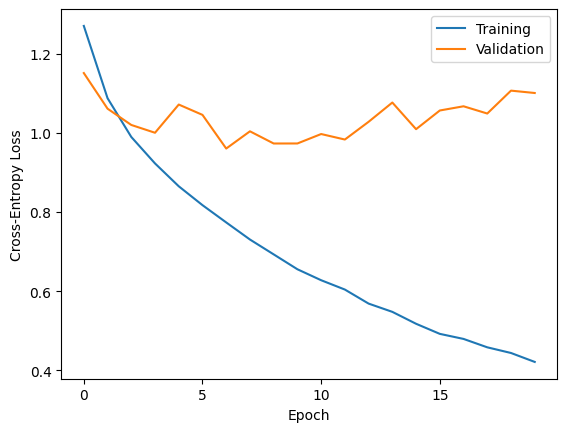

In [12]:
plot_training(best_training_history, best_validation_history)
evaluate_classifier(best_classifier, verbose=True)

Notice how after six epochs or so, validation loss stops decreasing and starts wiggling, indicating overfitting. Hence, we will re-train our optimal model to that number of epochs.

Let's visualize what the optimal parameter combination was:

In [ ]:
print("The optimal parameter combination was: ", best_parameters)

The optimal parameter combination was:  {'learning_rate': 0.0001, 'hidden_neurons': 32, 'dropout_chance': 0.5, 'momentum': 0.5}


Notice how the learning rate and momentum were the lowest possible, while the dropout chance was the highest. This, together with the plot of the validation indicate that the model is clearly overfit.

In order to try to get the best possible classifier, we will repeat training only for the optimal parameters and number of epochs:

Optimal number of epochs: 6
Accuracy: 63.800%
F1-score: 0.642


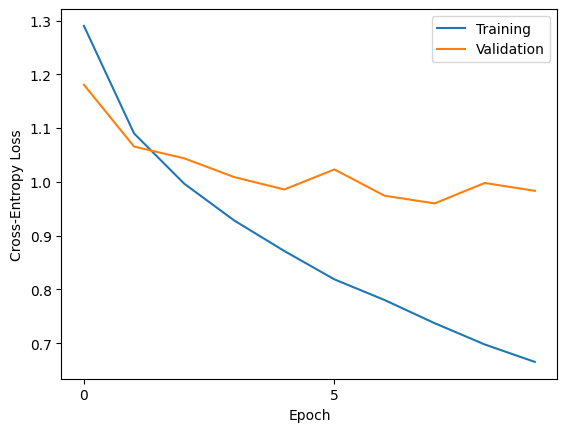

In [44]:
optimal_epochs = np.argmin(best_validation_history)
print("Optimal number of epochs:", optimal_epochs)
training_history, validation_history, classifier = train_classifier(n_epochs=10, **best_parameters)
accuracy, f1 = evaluate_classifier(classifier, verbose=True)

plot_training(training_history, validation_history)

The accuracy obtained was not much better than before.

## Conclusions

Simple feed-forward neural networks were used as an attempt to classify the provided dataset. In no case was the accuracy obtained higher than 65%. We point toward three possible causes of this poor performance:

1. The dataset may not be well prepared. In the book there are some examples of misclassified samples which have seemingly wrong labels. This noise in the data may cause an important loss of accuracy for any classifier. Also, perhaps the provided splits were not properly balanced.
2. The language model used was small. A weight file of less than 300MB is remarkably small in the context of language models. Usually, language models' weights lay in the order of gigabytes. A poor hidden-state representation of the samples will definately lead to a poor classification, which may be what is happening here.
3. Attempting to use all of the tokens instead of only the `[CLS]` one introduces unnecessary complexity. If one wishes to use the full sequences, it is necessary to introduce padding. This leads to all input samples for our classifier having an extremely large dimensionality, especially when compared to the training set size ($66818$ dimensions for $16000$ samples). Therefore, both a noisy input and a huge number of weights make it very hard for the classifier to generalize well.